In [ ]:
import numpy as np

import tensorflow as tf
import tensorflow_model_optimization as tfmot

import matplotlib.pyplot as plt 
from matplotlib import patches

import model.utils as utils
import model.export as export

from model.ssd_mobilenet import SSDMobileNetV2
from model.losses import SSDDetLoss
from model.anchors import SamplesEncoder, Anchors, AnchorsMobileNet
from model.export import save_model_tflite, save_model_quantized, custom_postprocess
from model.utils import show_patches, post_process_anchor, compute_iou, to_xywh
from model.quant import quantize_model, TFLiteModel, tflite_export

from spike_data import SpikeDataset

In [3]:
FULL_MODEL_SAVE = "checkpoint.h5"
NUM_CLASSES = 2 
BATCH_SIZE = 1
ANCHOR_GENERATOR = AnchorsMobileNet
QUANT_AWARE = True

loss = SSDDetLoss(num_classes=NUM_CLASSES, anchor_generator=ANCHOR_GENERATOR)
opt = tf.keras.optimizers.Adam(0.0001)

if QUANT_AWARE:
    
    with tfmot.quantization.keras.quantize_scope():
        model = tf.keras.models.load_model(FULL_MODEL_SAVE, 
                                       custom_objects={
                                           "box_loss_":loss.box_loss_, 
                                           "embed_loss_":loss.embed_loss_, 
                                           "zero_loss_":loss.zero_loss_, 
                                           "det_loss_": loss.det_loss_
                                       })
else:
    model = tf.keras.models.load_model(FULL_MODEL_SAVE, 
                                       custom_objects={
                                           "box_loss_":loss.box_loss_, 
                                           "embed_loss_":loss.embed_loss_, 
                                           "zero_loss_":loss.zero_loss_, 
                                           "det_loss_": loss.det_loss_
                                       })

model.compile(opt, [loss.box_loss_, loss.zero_loss_, loss.det_loss_])

train_dataset = SpikeDataset(
    ["data\\REC_32C_1200S_11"], #, "data\\REC_32C_600S_31" # hybrid_static_siprobe_64C_600_S12
    batch_size=BATCH_SIZE, 
    anchor_generator=ANCHOR_GENERATOR, 
    target_embedding=False, 
    augmentation = False
)()



In [4]:
def calc_cross_iou(box_gt, box_pred, threshold=0.1):
    
    ious = None
    #for gt_i in range(1):#len(labels_gt[labels_gt > 0])):

    iou = compute_iou(box_gt, box_pred, corner_format=True)

    if ious is None:
        ious = iou
    else:
        ious = tf.concat([ious, iou], axis=0)

    if ious is None:
        ious = [] 

    ious = ious.numpy()

    ious[ious < threshold] = 0
    
    paddings = tf.constant([[0, 0], [1,0]])
    ious = tf.pad(ious, paddings, "CONSTANT" ) ## need padding for false positives

    ious = tf.math.argmax(ious, axis=1)    
    ious = ious - 1 # to compensate for the padding 
    
    return ious 

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib qt

def res(x, label):
    
    uni = np.unique(label)
    for u in uni:
        
        lu = label[label==u]
        xu = x[label==u]
        
        rgb = np.random.rand(3,)
        plt.scatter(xu[:,0], xu[:,1], color=[rgb])
        
    plt.show(block=True)
        
def visualize_res(features, gt_labels, use_tsne=True):

    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', verbose=True, perplexity=30)

    #print(main_res)

    result = pca.fit_transform(features)
    
    if use_tsne:
        result = tsne.fit_transform(features)

    res(result, gt_labels)
    
    return result


In [6]:
def next_inference3(
        dataset, 
        threshold=0.1, 
        nms_threshold=0.2, 
        score_threshold=0.9, 
        just_center=False,
        add_position=False,
        vis_error = False
    ):
    
    detections = []
    true_labels = []
    
    fn = 0
    fp = 0
    p=0
    
    gt = dataset[0]
    ytrue = dataset[1]
    
    target_length = 42
    
    for gt_input, y_box, y_embed, y_label  in zip(gt, ytrue[0], ytrue[1], ytrue[2]):
        
        print(f"{p}", end="\r")
        p+=1
        
        
        boxes_gt, embeddings_gt, gt_valid_outputs, gt_indices = custom_postprocess((y_box, y_embed, y_label), threshold=nms_threshold, score_threshold=score_threshold, pad_to_max=False, anchor_generator=ANCHOR_GENERATOR)
        
        labels_gt = tf.gather(y_label[0], gt_indices)
               
        results = model.predict(gt_input)
        sample_pred, pred_embeddings, pred_valid_outputs, pred_indices = custom_postprocess(results, threshold=nms_threshold, score_threshold=score_threshold, pad_to_max=False, anchor_generator=ANCHOR_GENERATOR)
        
        if just_center: 
            
            center_idx = tf.math.argmin(tf.math.abs(53-boxes_gt[...,1]))
            boxes_gt = tf.expand_dims(tf.gather(boxes_gt, center_idx), axis=0)
            labels_gt = tf.expand_dims(tf.gather(labels_gt, center_idx), axis=0)
            
            
            gt_valid_outputs = 1 
            
        
        extremity_gt = tf.logical_and(
                            tf.equal(target_length, boxes_gt[...,3]-boxes_gt[...,1]), # if the spike is present on its enitre length
                            tf.logical_and(
                                tf.less(boxes_gt[...,3], 128),
                                tf.greater(boxes_gt[...,1], 0)
                            )
                        )
        boxes_gt = tf.boolean_mask(boxes_gt, extremity_gt)
        labels_gt = tf.boolean_mask(labels_gt, extremity_gt)
        
        
        
        extremity_pred = tf.logical_and( # if the spike is present on its enitre length
                                tf.logical_and(
                                    tf.greater_equal(sample_pred[...,3]-sample_pred[...,1], target_length-2), 
                                    tf.less_equal(sample_pred[...,3]-sample_pred[...,1], target_length+2)
                                ),
                                tf.logical_and(
                                    tf.less(sample_pred[...,3], 127),
                                    tf.greater(sample_pred[...,1], 1)
                                )
                            )
               
        sample_pred = tf.boolean_mask(sample_pred, extremity_pred)
        pred_embeddings = tf.boolean_mask(pred_embeddings, extremity_pred)
        
        
        
        if gt_valid_outputs <= pred_valid_outputs:
            
            
            ious = calc_cross_iou(boxes_gt, sample_pred, threshold)
            
            ious_indexes = tf.where(tf.greater_equal(ious, 0))
            pos_ious = tf.gather(ious, ious_indexes)
            
            if just_center: 
                fp_n = 1 - pos_ious.shape[0]
            else:
                fp_n = sample_pred.shape[0] - pos_ious.shape[0]

            
            fn_n =  boxes_gt.shape[0] - ious_indexes.shape[0]
            
            sample_pred = tf.gather(sample_pred, pos_ious)
            pred_embeddings = tf.gather(pred_embeddings,  pos_ious)
            labels_gt = tf.gather(labels_gt, ious_indexes)
            boxes_gt = tf.gather(boxes_gt, ious_indexes)
            
        else:
            
            if just_center: # at this point it means that no box predictions were made so we add 1 to FN and continue
                fn_n = 1 
                continue 
                
            ious = calc_cross_iou(sample_pred, boxes_gt, threshold)
            
            ious_indexes = tf.where(tf.greater_equal(ious, 0))
            pos_ious = tf.gather(ious, ious_indexes)
            
            fp_n = sample_pred.shape[0] - pos_ious.shape[0]
            fn_n = boxes_gt.shape[0] - ious_indexes.shape[0]
            
            sample_pred = tf.gather(sample_pred, ious_indexes)
            pred_embeddings = tf.gather(pred_embeddings,  ious_indexes)
            labels_gt = tf.gather(labels_gt, pos_ious)
            boxes_gt = tf.gather(boxes_gt, pos_ious)
            
        
        fp = fp + fp_n
        fn = fn + fn_n
        
        boxes_gt = tf.squeeze(boxes_gt, axis=1)
        sample_pred = tf.squeeze(sample_pred, axis=1)
        pred_embeddings = tf.squeeze(pred_embeddings, axis=1)
        
        
        det = pred_embeddings
        
        if add_position:
            det = tf.concat([(sample_pred[:, :1]), pred_embeddings], axis=-1)
    
        detections.extend(det)
        true_labels.extend(labels_gt)
        
        
        
    detections = np.array(detections)
    true_labels = np.array(true_labels)
    
    detections = detections.astype(np.float32)
    
    detections = np.squeeze(detections)
    true_labels = np.squeeze(true_labels)
    
    print()
    
    
    return detections, true_labels, fp, fn
    
#next_inference(train_dataset.take(1))

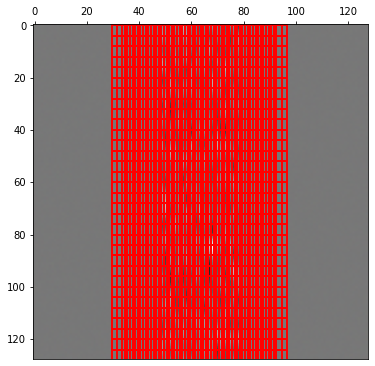

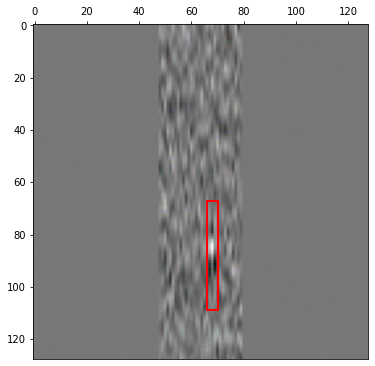

In [7]:
#"""
%matplotlib inline 
from model.utils import to_corners

s_a = ANCHOR_GENERATOR()
anchors = s_a.get_anchors()
sample = next(iter(train_dataset))


show_patches(sample[0][0], to_corners(anchors* [[128,128,128,128]]))


boxes, scores, labels = post_process_anchor(sample[1], anchor_generator=ANCHOR_GENERATOR)

show_patches(sample[0], boxes)
#"""

In [9]:
#from coclust.evaluation.external import accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.optimize import linear_sum_assignment as linear_assignment


def evaluate_sorting(gt_labels, pred_labels):
    
    n_clust_diff = gt_labels.shape[0] - pred_labels.shape[0]
    
    gt_labels = gt_labels -1 
    
    if len(np.unique(gt_labels)) == 1:
        return min(gt_labels.shape[0], pred_labels.shape[0]), 0, 0, pred_labels
    
    cm = confusion_matrix(gt_labels, pred_labels)

    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)

    indexes = linear_assignment(_make_cost_m(cm))
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, indexes[1]] ## orig js
    
    
    for i, v in enumerate(indexes[1]):
        pred_labels[pred_labels==i] = v
    
    tp = np.diag(cm2)

    fp = np.sum(cm2, axis=0) - tp
    fn = np.sum(cm2, axis=1) - tp

    return tp, fp, fn, pred_labels

    

In [10]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
import sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
import isosplit5
import time 
from spclustering import SPC
from sklearn.cluster import AgglomerativeClustering

def sort_(features, gt_labels, vis=False, verbose=False, use_max = False, use_reduced=False, reduce_to=5):
    no_unique_clusters = np.unique(gt_labels).shape[0]
    print(f"Unique clusters : {no_unique_clusters}")

    best_clust_num = 0
    best_sil_score = 0
    pred_labels = None
    cluster_centers = None 
    
    if use_reduced: 
        pca = PCA(n_components=reduce_to)
        tsne = TSNE(n_components=2, learning_rate='auto', init='random', verbose=True, perplexity=30)
        features = pca.fit_transform(features)
        #features = tsne.fit_transform(features)
    
    def calc_sil_score(sil_score, cluster_num):
        return sil_score + cluster_num / 1000
    
    ##############################################################
    ##############################################################
    ####################### ISOSPLIT #############################
    #"""
    t1 = time.time()
    pred_labels = isosplit5.isosplit5(np.rollaxis(features, axis=1))
    print(f"ISOSPLIT TIME IS: {time.time() - t1}")
    
    print("Clustering finished, now calculating adjusted rand score ... ")
    best_score = sklearn.metrics.adjusted_rand_score(gt_labels, pred_labels)
    
    print(f"Best Adjusted_rand_score for ISOSCORE is {best_score}")
    
    gt_labels = np.array(gt_labels)
    pred_labels = np.array(pred_labels)
    
    tp, fp, fn, pred_labels = evaluate_sorting(gt_labels, pred_labels)
    
    print(f"ACC for ISOSPLIT: {np.sum(tp)/(np.sum(tp)+np.sum(fp)+np.sum(fn))}")
    
    print("\n--------------------------------------------\n")
    #"""
    
    ##############################################################
    ##############################################################
    ############# AgglomerativeClustering ########################
    
    from sklearn.neighbors import kneighbors_graph
    
    t11 = time.time()
    
    A = kneighbors_graph(features, 5, mode='connectivity', include_self=True)
    
    t12 = time.time()
    
    clustering = AgglomerativeClustering(None, distance_threshold=5.5, connectivity=A)
    
    
    t1 = time.time()
    
    pred_labels = clustering.fit_predict(features)

    print(f"Agglomaretive CLUSTERING TIME IS: {time.time() - t1 + (t12-t11)}")
    
    print(f"Clustering finished {pred_labels.shape}, now calculating adjusted rand score ... ")
    best_score = sklearn.metrics.adjusted_rand_score(gt_labels, pred_labels)
    
    print(f"Best Adjusted_rand_score for Agglomaretive is {best_score}")
    
    gt_labels = np.array(gt_labels)
    pred_labels = np.array(pred_labels)
    
    tp, fp, fn, pred_labels = evaluate_sorting(gt_labels, pred_labels)
    
    print(f"ACC for Agglomerative: {np.sum(tp)/(np.sum(tp)+np.sum(fp)+np.sum(fn))}")
    print("\n--------------------------------------------\n")
    
    
    if vis:
        visualize_res(features, pred_labels)
        
    return tp, fp, fn, pred_labels


In [11]:
def calc_performance(tp, fp, fn, det_fp=0, det_fn=0):
    
    all_count = tp+fn
    
    tp = np.sum(tp)
    fp = np.sum(fp) + det_fp
    fn = np.sum(fn) + det_fn
    all_count = np.sum(all_count) + det_fn
    
    
    tp_rate = float(tp) / all_count*100
    fn_rate = float(fn) / all_count*100
    fp_rate = float(fp) / all_count*100
    
    
    accuracy = tp_rate / (tp_rate + fn_rate + fp_rate) * 100
    
    sensitivity = tp_rate / (tp_rate + fn_rate) * 100
    precision = tp_rate / (tp_rate + fp_rate) * 100
    
    miss_rate = fn_rate / (tp_rate + fn_rate) * 100
    
    print(f"ACC: {accuracy}% , Sensitivity: {sensitivity}, Precision: {precision}")
    

In [12]:
## INIT 

%matplotlib qt 
batches=512
use_reduced = False
    
dets_all = []
gt_labels_all = []

fp = None
fn = None
tp = None
det_fp_sum = 0
det_fn_sum = 0
det_acc_list = []

new_ds = train_dataset.batch(batches)

In [13]:
def concat_vectors(a, b):
    
    max_shape = max(a.shape[0], b.shape[0])
    
    z = np.zeros((max_shape,))

    z[:a.shape[0]] = a
    z[:b.shape[0]] = z[:b.shape[0]] + b

    return z 


In [ ]:
def get_dataset_results(sort_per_batch=20, paired=False): 
    
    dets_all = []
    gt_labels_all = []

    fp = np.array([])
    fn = np.array([])
    tp = np.array([])
    det_fp_sum = 0
    det_fn_sum = 0
    
    det_acc_all = []
    
    for i, ds in enumerate(new_ds):
        
        print(f"Big loop nr. {i} ---------------------------------")
        if i > 0 and i % sort_per_batch == 0:
            
            dets_all = np.array(dets_all)
            gt_labels_all = np.array(gt_labels_all)

            if not paired:
                print(f"\n\nSORTING COMMENCE AT {i} --------------------------------------")
                tp_i, fp_i, fn_i, pred_labels = sort_(dets_all, 
                                                      gt_labels_all, 
                                                      use_max = True, 
                                                      vis=False, 
                                                      verbose=False, 
                                                      use_reduced=False, 
                                                      reduce_to=10
                                                     )

                tp = concat_vectors(tp,tp_i)
                fn = concat_vectors(fn,fn_i)
                fp = concat_vectors(fp,fp_i)
            
            
            
            dets_all = []
            gt_labels_all = []
            print("\n\n\n")
            
        dets, gt_labels, det_fp, det_fn = next_inference3(
                                    ds, 
                                    score_threshold=0.80,
                                    just_center=False, 
                                    add_position=True
                            )
        
        if paired:
            det_fp = 0
            
        det_acc = dets.shape[0] / (dets.shape[0]+det_fp+det_fn)
        
        det_acc_all.append([dets.shape[0], det_fp, det_fn])
        
        det_fp_sum = det_fp_sum + det_fp
        det_fn_sum = det_fn_sum + det_fn
        
        print(f"{i} : Detection accuracy: {det_acc}, with FP {det_fp}, FN {det_fn}")

        if use_reduced:
            dets = dets_reduced

        if isinstance(dets_all, list):
            dets_all.extend(dets)
            gt_labels_all.extend(gt_labels)

        else:
            dets_all = np.concatenate([dets_all, dets], axis=0)
            gt_labels_all = np.concatenate([gt_labels_all, gt_labels], axis=0)
    
    det_acc_all = np.array(det_acc_all)
    
    final_avg_detection_accuracy = np.sum(det_acc_all[:,0]) / (np.sum(det_acc_all[:,0])+np.sum(det_acc_all[:,1])+np.sum(det_acc_all[:,2]))
    
    print(f"AVERAGE DETECTION ACCURACY: {final_avg_detection_accuracy}")
    calc_performance(tp, fp, fn, det_fp_sum, det_fn_sum) ## final metrics is this 
    calc_performance(tp, fp, fn) ## without detection loss
    



Big loop nr. 0 ---------------------------------
511
0 : Detection accuracy: 0.48569023569023567, with FP 200, FN 411
Big loop nr. 1 ---------------------------------
511
1 : Detection accuracy: 0.49876135425268375, with FP 178, FN 429
Big loop nr. 2 ---------------------------------
511
2 : Detection accuracy: 0.4773310521813516, with FP 189, FN 422
Big loop nr. 3 ---------------------------------
511
3 : Detection accuracy: 0.47538200339558573, with FP 195, FN 423
Big loop nr. 4 ---------------------------------
511
4 : Detection accuracy: 0.49413735343383586, with FP 188, FN 416
Big loop nr. 5 ---------------------------------
511
5 : Detection accuracy: 0.4991721854304636, with FP 173, FN 432
Big loop nr. 6 ---------------------------------


In [ ]:
get_dataset_results(paired=False)